In [10]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-l6_dnn8d
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-l6_dnn8d
  Resolved https://github.com/tensorflow/examples.git to commit 2741d0f2a345ef52e0de1d498de732f5dacbf2f0
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1694556533.224118390420868118806081040175592332373432988400-py3-none-any.whl size=301567 sha256=9f627ebfcb2ad8fa9cc1c87ed25cd1ebf1c3ec558c44b266a50a65018861778f
  Stored in directory: /tmp/pip-ephem-wheel-cache-zz60zgje/wheels/72/5f/d0/7fe769eaa229bf20101d11a357eb23c83c481bee2d7f710599
Successfully built tensorflow-examples


In [11]:
# Import libraries
import datetime
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow_examples.models.pix2pix import pix2pix
from IPython.display import clear_output
import matplotlib.pyplot as plt

# Load dataset

The dataset `rooftop` is a subset of this [dataset](https://zenodo.org/record/5171712).
The dataset get uploaded to the Google Colab environment, and then unpacked and added to a dataset.

Note: Prior to loading the dataset in this notebook, the original images provided under above link have been changed from `.bmp` format to `jpg` format and saved. The script can be found in the `utils` folder.

In [ ]:
# After uploading the ziped images to the Colab environment, they will be
# unzipped with following code
!unzip "/content/rooftop_jpg.zip"

In [111]:
# Load images from directory shuffle, and split them 70/30 into train and test datasets
# Data will not be batched in this step
# Because both function calls use the same seed, the splits and shuffles for images and masks are same
images_train, images_test = tf.keras.utils.image_dataset_from_directory(
    "/content/rooftop_jpg/images",
    labels=None,
    shuffle=True,
    validation_split=0.3,
    subset="both",
    batch_size=None,
    seed=42
    )

# The masks dataset will be loaded as grayscale which results
# in only one channel and format (none, none, 1) of the images
masks_train, masks_test = tf.keras.utils.image_dataset_from_directory(
    "/content/rooftop_jpg/masks",
    labels=None,
    shuffle=True,
    validation_split=0.3,
    subset="both",
    color_mode='grayscale',
    interpolation='nearest',
    batch_size=None,
    seed=42
    )

# Combine images and masks together in a dataset
dataset_train = tf.data.Dataset.zip((images_train, masks_train))
dataset_test = tf.data.Dataset.zip((images_test, masks_test))

Found 138 files belonging to 1 classes.
Using 97 files for training.
Using 41 files for validation.
Found 138 files belonging to 1 classes.
Using 97 files for training.
Using 41 files for validation.


In [ ]:
dataset = tf.data.Dataset.range(10).shuffle(buffer_size=1)


In [ ]:
dataset = dataset.take(10)
list(dataset.as_numpy_iterator())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# Create binary mask

The original masks of the used dataset where of the format (256, 256, 3). By loading them above as `grayscale`, we already reduced the channel to 1 and the format to (256, 256, 1). For training our model, we need a binary mask that either has the value `0` meaning "not PV panel" or `1` meaning "PV panel". The values inside the mask however contain values in a wide range which is likly due to prior conversations.
The following code shows the pixel values:


In [7]:
def display(display_list):
    """
    Funciton that takes in a list of images to display them next to each other
    for comparision and investigation.

    Args:
        display_list (list): list of images to display
    """
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.show()

In [ ]:
images_train

In [ ]:
for image in images_train.take(5):
    #print("\nUnique pixel values: \n",np.unique(mask))
    display([image])


Unique pixel values: 
 [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  26  29  33 183 190 191 192 193 194 195 196 197 198 199 200
 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218
 219 220 221 222 223 224 225 226 227 228 229 230 232 234 235 237 238 239
 243 245]


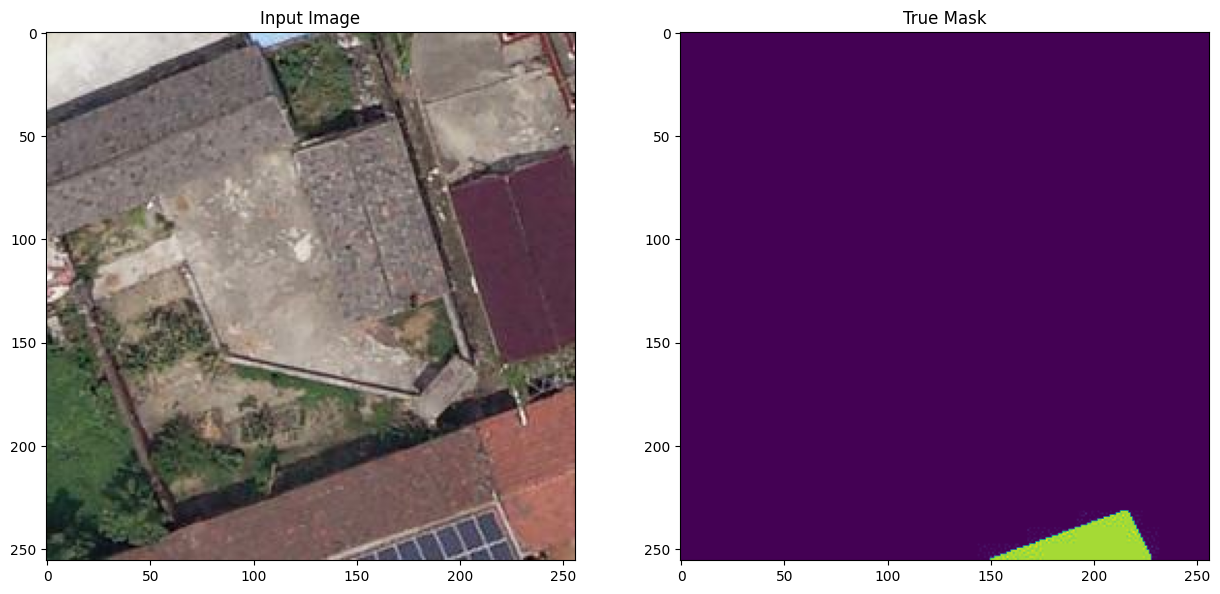

In [12]:
for image, mask in dataset_train.take(1):
    print("\nUnique pixel values: \n",np.unique(mask))
    display([image, mask])

In the following we create the binary mask and transform the values.

In [13]:
def create_binary_mask(mask):
    """
    Function that maps all pixel values of mask either to 0 or 1
    and returns a binary mask
    """

    # Threshold value of pixel (between 0 and 255)
    threshold = 127

    binary_mask = tf.where(mask > threshold, 1, 0)
    return binary_mask

In [151]:
dataset_train_adjusted = dataset_train.map(lambda image, mask: (image, create_binary_mask(mask)))
dataset_test_adjusted = dataset_test.map(lambda image, mask: (image, create_binary_mask(mask)))


Unique pixel values: 
 [0 1]


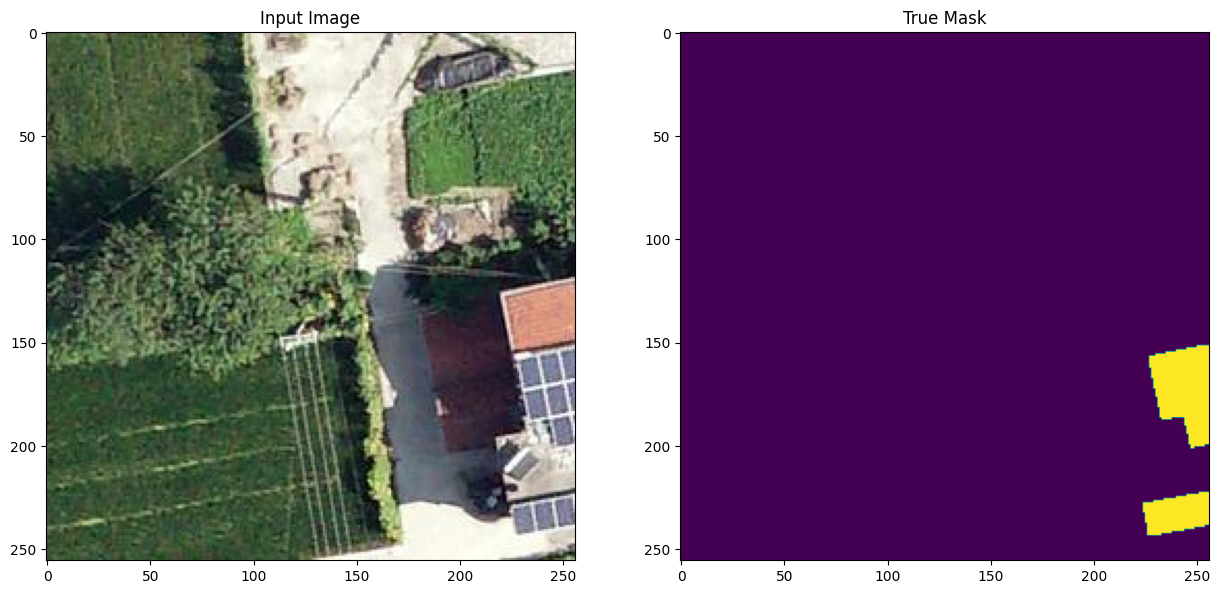

In [152]:
for image, mask in dataset_train_adjusted.take(1):
    print("\nUnique pixel values: \n",np.unique(mask))
    display([image, mask])

It can be seen, that all values are now mapped to either `0` or `1` and that the mask has a sharp edge.

# Building out the data pipeline

Now that we have the dataset loaded, we will create pipeline for augmenting and preparing the data for training.

In [153]:
class Preprocess(tf.keras.layers.Layer):
    """
    Layer that rescales image pixel values between 0 and 1 and resizes
    images and masks to 128, 128.
    """
    def __init__(self):
        super().__init__()

        # Layers for both
        self.rescaling = tf.keras.layers.Rescaling(1.0/255)

        # Layers for images
        self.resizing_images = tf.keras.layers.Resizing(128, 128, interpolation='bilinear')

        # Layers for masks
        self.resizing_masks = tf.keras.layers.Resizing(128, 128, interpolation='nearest')

    def call(self, images, masks):
        images = self.rescaling(images)
        images = self.resizing_images(images)

        masks = self.resizing_masks(masks)

        return images, masks

In [154]:
class Augment(tf.keras.layers.Layer):
    """
    Layer that performs random augmentations on image and mask
    """
    def __init__(self, seed=42):
        super().__init__()
        # both use the same seed, so they'll make the same random changes.
        # Layers for images

        self.randombrightness_images = tf.keras.layers.RandomBrightness(0.2, value_range=[0.0, 1.0], seed=seed)
        self.randomcontrast_images = tf.keras.layers.RandomContrast(0.2, seed=seed)
        self.randomflip_images = tf.keras.layers.RandomFlip(mode="horizontal_and_vertical", seed=seed)
        self.randomrotation_images = tf.keras.layers.RandomRotation(0.125, fill_mode='constant', interpolation='bilinear', fill_value=0.0, seed=seed)

        # Layers for masks
        self.randomflip_masks = tf.keras.layers.RandomFlip(mode="horizontal_and_vertical", seed=seed)
        self.randomrotation_masks = tf.keras.layers.RandomRotation(0.125, fill_mode='constant', interpolation='nearest', fill_value=0.0, seed=seed)

    def call(self, images, masks):
        images = self.randombrightness_images(images)
        images = self.randomcontrast_images(images)
        images = self.randomflip_images(images)
        images = self.randomrotation_images(images)
        masks = self.randomflip_masks(masks)
        masks = self.randomrotation_masks(masks)

        return images, masks

Create the train and test batches.

In [158]:
BUFFER_SIZE = 1000
BATCH_SIZE = 16

train_batches = (
    dataset_train_adjusted
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Preprocess())
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE)
    )

test_batches = (
    dataset_test_adjusted
    .batch(BATCH_SIZE)
    .map(Preprocess())
)

Check the preprocessing and augmentations.

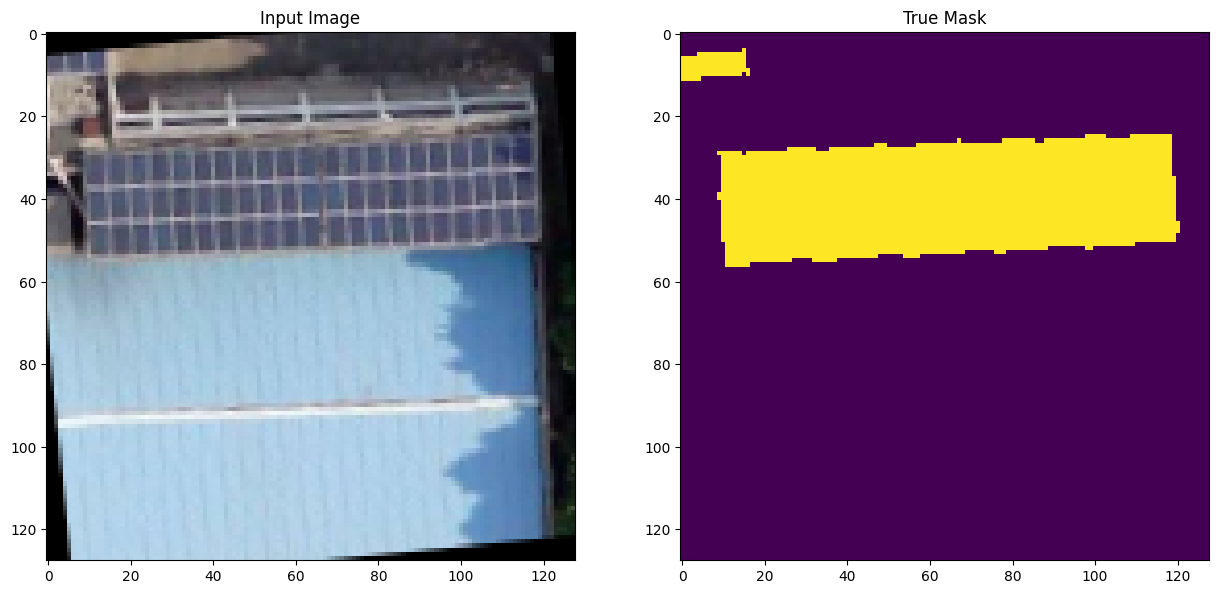

In [157]:
for image, mask in train_batches.take(1):
    display([image[0], mask[0]])

# Create the model

In [21]:
#TRAIN_LENGTH = info.splits['train'].num_examples
TRAIN_LENGTH = 97
BATCH_SIZE = 16
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [22]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [23]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8 3
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16 3
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32 3
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64 3
]

In [267]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2, #kernel_size=3
      padding='same')  #64x64 -> 128x128

  x = last(x)
  # experimental
  #x = tf.keras.layers.Activation('sigmoid')(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [223]:
metric = tf.keras.metrics.IoU(num_classes=2, target_class_ids=[1])

In [285]:
OUTPUT_CLASSES = 1#3#2

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              #loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
              #metrics=metric)

In [ ]:
# Uncomment for loading the weights
# Select the weights to be loaded
file_name = "2023-10-12_weights_model_unet"

model.load_weights(file_name)

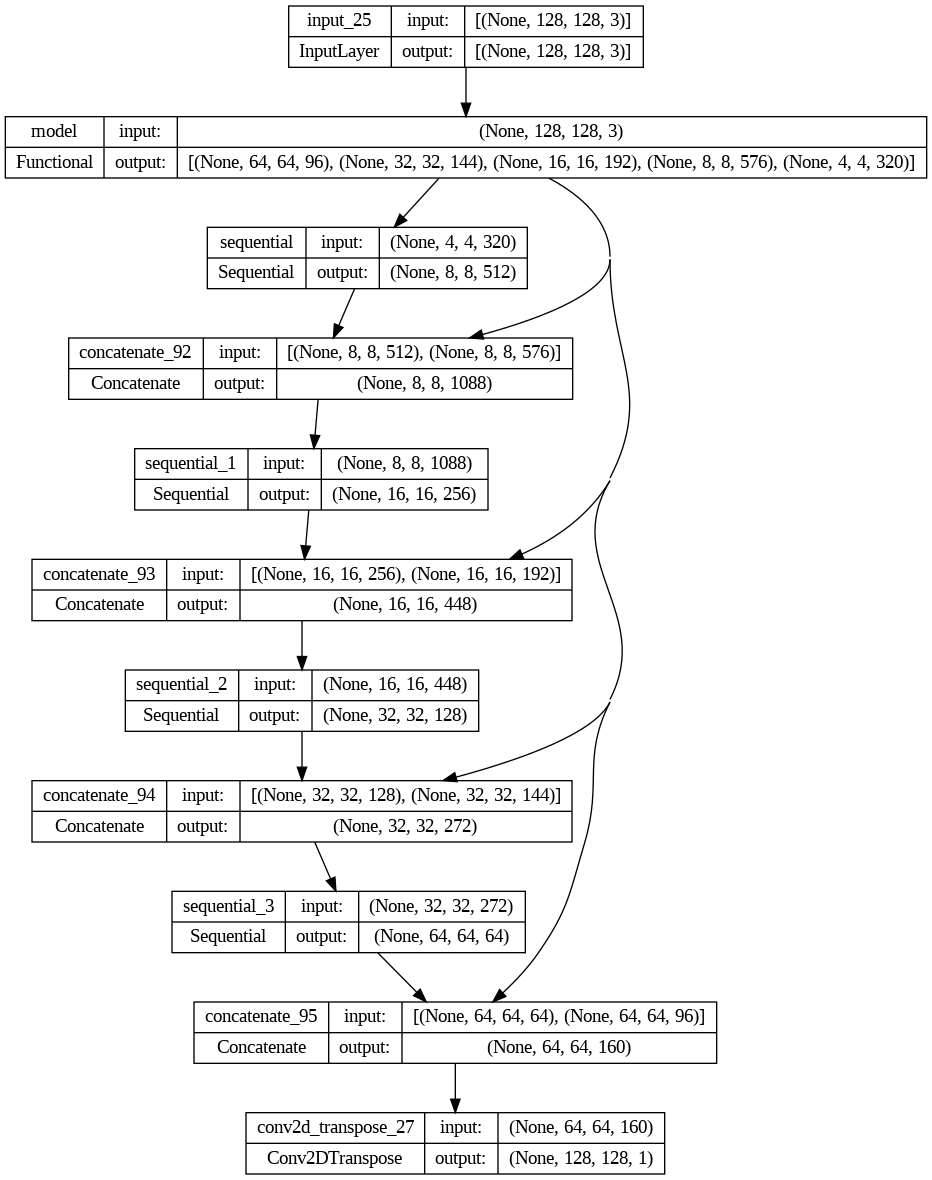

In [286]:
tf.keras.utils.plot_model(model, show_shapes=True)

Try out the model to check what it predicts before training:

In [275]:
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [296]:
for image, mask in train_batches.take(1):
    pred_mask = model.predict(image)
    pred_mask = tf.keras.layers.Activation('sigmoid')(pred_mask)
    pred_mask = tf.where(pred_mask >= 0.5, 1, 0)
    print(pred_mask[0])
    #print(bce(mask[0], pred_mask[0]).numpy())
    #bce(y_true, y_pred).numpy()

1/1 [==============================] - 1s 1s/step
tf.Tensor(
[[[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 ...

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]], shape=(128, 128, 1), dtype=int32)


In [274]:
for images, masks in train_batches.take(1):
  sample_image, sample_mask = images[1], masks[1]
  #display([sample_image, sample_mask])
  print(sample_image.shape)
  print(sample_mask.shape)

(128, 128, 3)
(128, 128, 1)


In [294]:
pred = model.predict(train_batches.take(1))
print(pred[0])
pred_mask = tf.math.argmax(pred[0], axis=-1)
#print(pred_mask)
#pred_mask = tf.where(pred[0] >= 0.5, 1, 0)
pred_mask = pred_mask[..., tf.newaxis]
print(pred_mask)

1/1 [==============================] - 3s 3s/step
[[[-2.65103  ]
  [-2.0575135]
  [-3.1153932]
  ...
  [-1.4627949]
  [-4.072433 ]
  [-1.8557568]]

 [[-2.1915624]
  [-3.6944704]
  [-3.8620043]
  ...
  [-4.1475873]
  [-3.6359959]
  [-3.936328 ]]

 [[-3.2893748]
  [-2.716331 ]
  [-3.9175167]
  ...
  [-1.9964832]
  [-5.613005 ]
  [-3.5004146]]

 ...

 [[-2.7702496]
  [-3.783765 ]
  [-4.2415314]
  ...
  [-3.2261348]
  [-3.8431723]
  [-3.2127826]]

 [[-2.6029978]
  [-3.1464186]
  [-3.6100173]
  ...
  [-2.9332075]
  [-3.714406 ]
  [-3.3307695]]

 [[-2.2644856]
  [-3.9473116]
  [-4.5280986]
  ...
  [-3.3664703]
  [-3.8603048]
  [-3.5218053]]]
tf.Tensor(
[[[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 ...

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]], shape=(128, 128, 1), dtype=int64)


In [250]:
pred_mask[0].shape

(128, 128, 1)

In [ ]:
pred_mask = tf.math.argmax(pred_mask[0], axis=-1)
pred_mask

<tf.Tensor: shape=(128, 128), dtype=int64, numpy=
array([[1, 1, 0, ..., 1, 0, 1],
       [0, 1, 0, ..., 1, 0, 1],
       [1, 1, 0, ..., 1, 0, 1],
       ...,
       [1, 0, 1, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 1, 0]])>

In [ ]:
pred_mask = pred_mask[..., tf.newaxis]
pred_mask

In [305]:
def create_masks(pred_masks):
    #pred_mask = tf.math.argmax(pred_mask, axis=-1)
    #pred_mask = pred_mask[..., tf.newaxis]

    pred_masks = tf.keras.layers.Activation('sigmoid')(pred_masks)
    pred_masks = tf.where(pred_masks >= 0.5, 1, 0)
    return pred_masks

In [ ]:
display([pred_mask])

1/1 [==============================] - 2s 2s/step


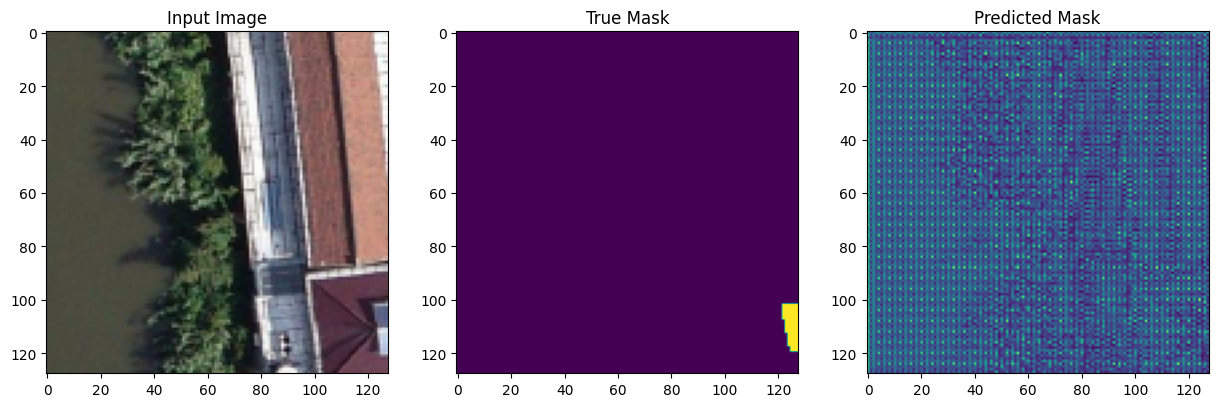

1/1 [==============================] - 2s 2s/step


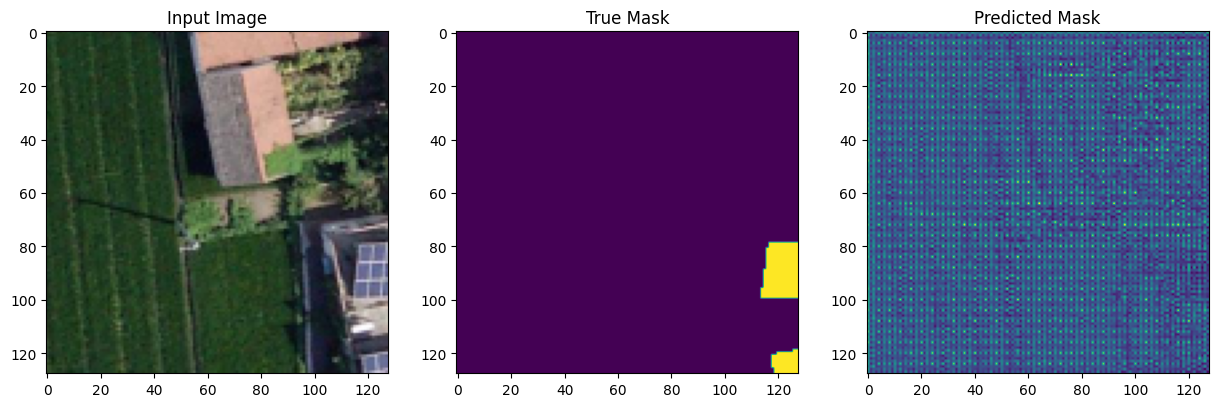

1/1 [==============================] - 0s 436ms/step


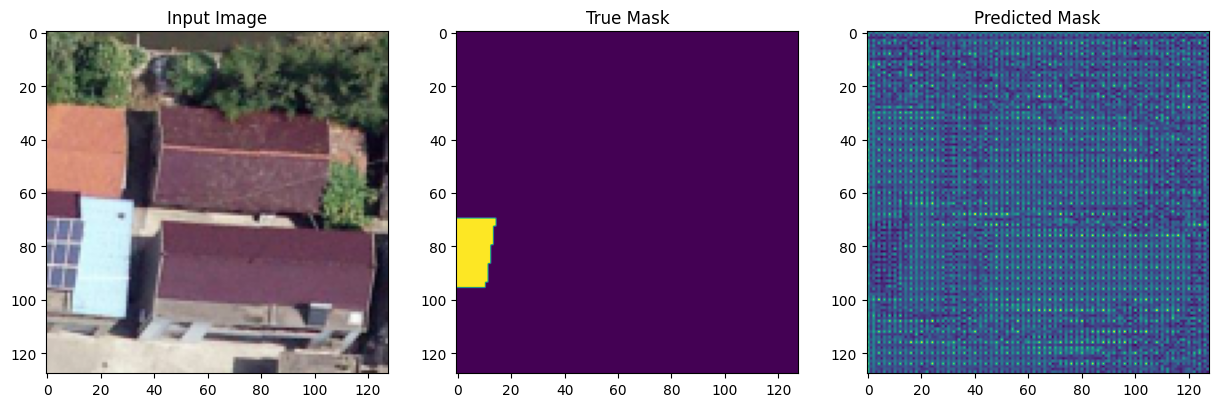

In [249]:
for image, mask in test_batches.take(10):
      pred_mask = model.predict(image)
      #display([image[0], mask[0], create_mask(pred_mask)])
      display([image[0], mask[0], pred_mask[0]])

In [309]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for images, masks in dataset.take(num):
      pred_masks = model.predict(images)
      display([images[0], masks[0], create_masks(pred_masks)[0]])
  else:
    display([sample_image, sample_mask,
             create_masks(model.predict(sample_image[tf.newaxis, ...]))[0]])

1/1 [==============================] - 0s 125ms/step


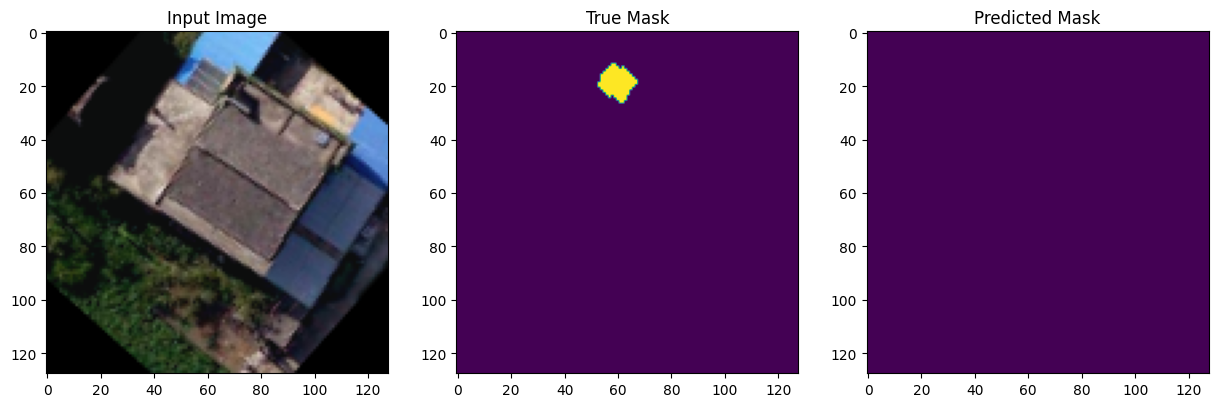

In [307]:
show_predictions()

In [297]:
class CustomDataCallback(tf.keras.callbacks.Callback):

    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        for batch in train_batches.take(1):
            images, masks = batch

        #display([images[0], masks[0], create_mask(model.predict(images[0][tf.newaxis, ...]))])
        pred_masks = model.predict(images)
        pred_masks = tf.keras.layers.Activation('sigmoid')(pred_masks)
        pred_masks = tf.where(pred_masks >= 0.5, 1, 0)

        display([images[0], masks[0], pred_masks[0]])
        print (f"\nSample Prediction after epoch {epoch+1}\n")

1/1 [==============================] - 1s 653ms/step


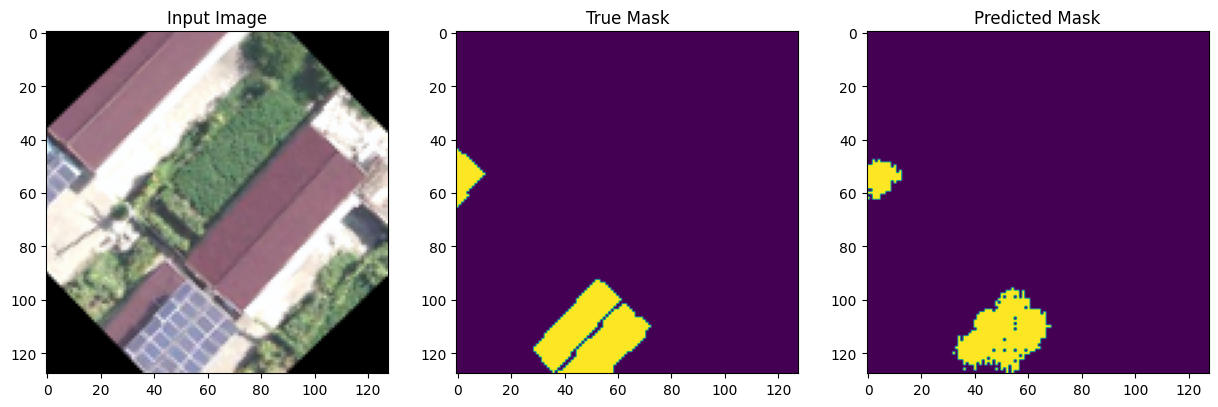


Sample Prediction after epoch 10

6/6 [==============================] - 15s 3s/step - loss: 0.0365 - accuracy: 0.9859 - val_loss: 0.0416 - val_accuracy: 0.9824


In [300]:
EPOCHS = 10

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_data=test_batches,
                          callbacks=[CustomDataCallback()])

# Save the weights
date = datetime.date.today()
file_name = f"{date}" + "_weights_model_unet"
model.save_weights(file_name, save_format="h5")

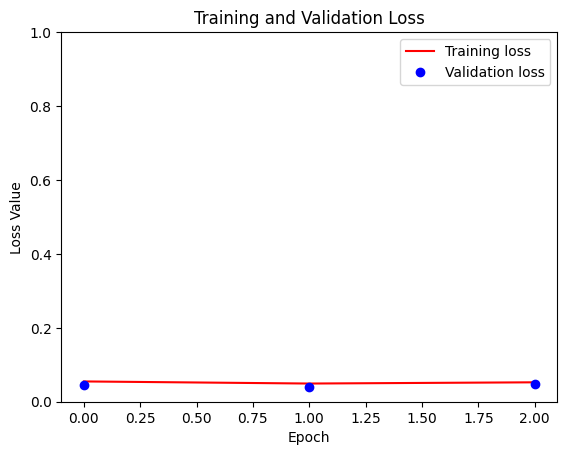

In [173]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

1/1 [==============================] - 1s 698ms/step


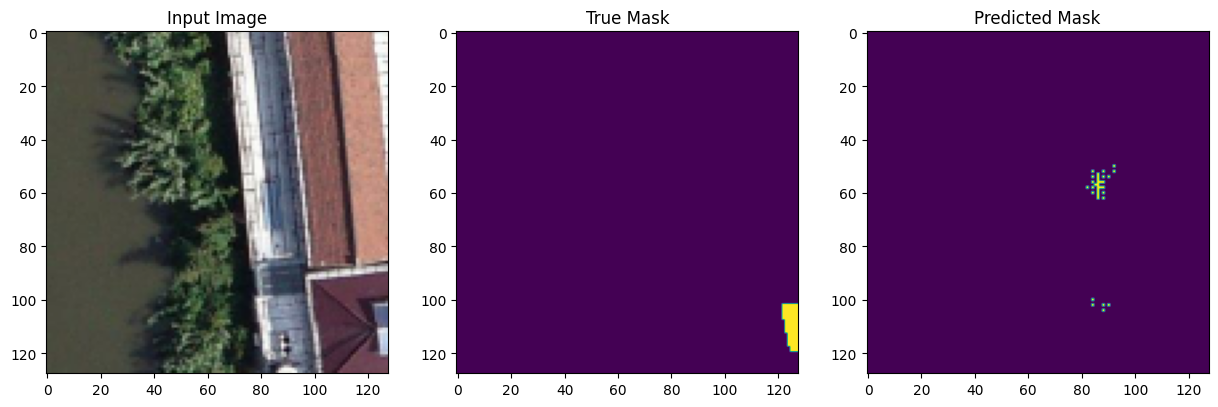

1/1 [==============================] - 1s 682ms/step


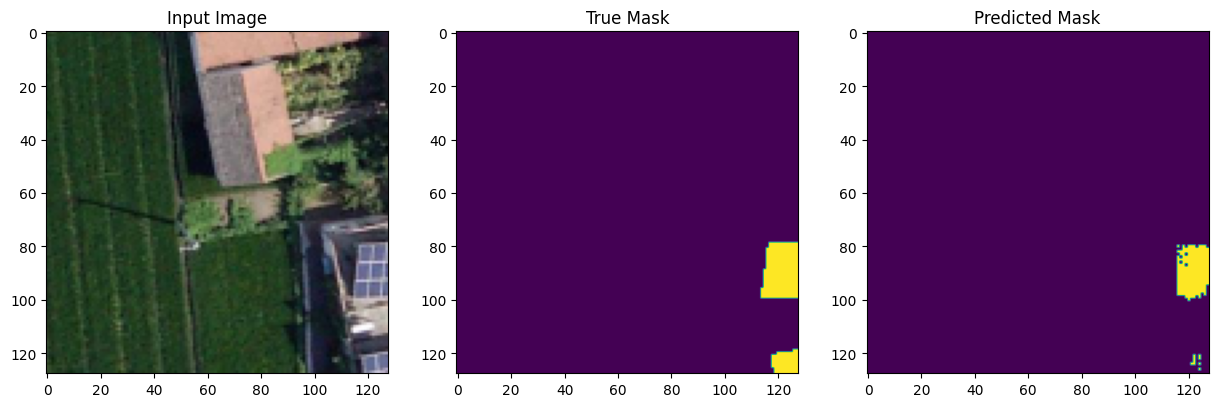

1/1 [==============================] - 0s 405ms/step


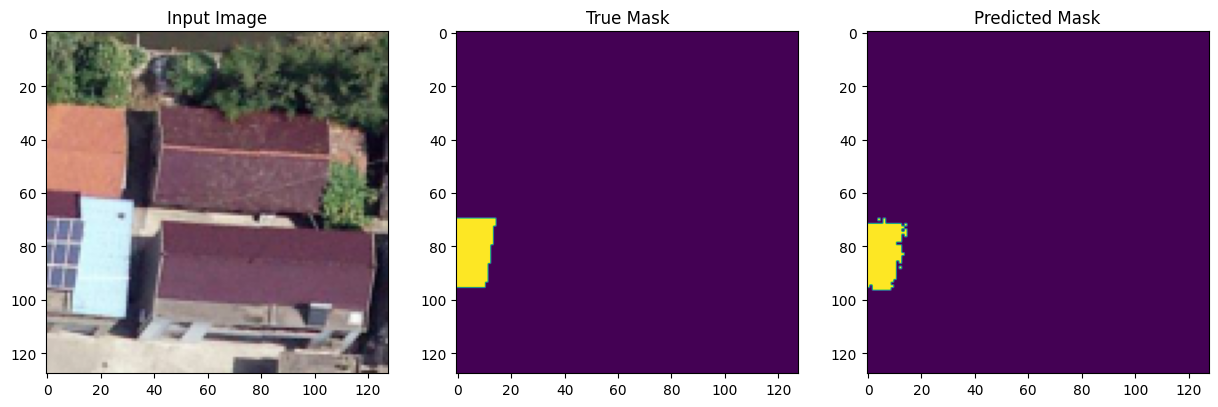

In [310]:
show_predictions(test_batches, 10)